### Traffic Flow analysis and forecasting using Machine Learning and Deep Learning Techniques

The data used for this research comes from a project called the cabspotting project. Specifically, this dataset contains about 11,000,000 GPS data of various taxis (Yellow Cab Vehicles) in the San Francisco, California area. The whole data sampling occurred in May 2008.

<b>You can read more about the dataset in the following link: </b>https://stamen.com/work/cabspotting/

### This notebook process the initial dataset, in order to extract usefull information from it. 
The rest of this notebook contains the code that we developed, in order to preprocess the dataset.

In [1]:
# measure execution time
%load_ext autotime

time: 0 ns (started: 2023-08-10 21:19:52 +03:00)


In [2]:
# import basic libraries
import os
import json
import random
import requests

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime, timedelta

%matplotlib inline

time: 9.2 s (started: 2023-08-10 21:19:52 +03:00)


### Phase 1: Preprocess the dataset
In this step, the following commands are executed:
- Add Taxi ID on the data
- Gather all the data in one txt file
- Convert time information to timestamp
- Split trajectories, based in the time field
- Delete unnecessary columns
- Map Matching using Valhalla Meili API

#### Step 1: Preprocess the initial dataset with raw data

In [ ]:
# define the path in which data are stored
path = 'C:/Users/SK/Desktop/Diploma_Thesis/Datasets/San-Francisco-Yellow-Cabs/Data'

In [3]:
counter = 0 # Taxi ID starts from 0

# create an empty dataframe, in which all the data will be saved
all_data = pd.DataFrame(columns=['Taxi ID','Latitude','Longitude','Occupied','Date Time'])

for filename in os.listdir(path):
    
    # read each file in the Data folder
    temp = pd.read_csv(path+'/'+filename,names=['Latitude','Longitude','Occupied','Date Time'],sep=' ')
    
    # assign Taxi ID number to each file
    temp.insert(1,'Taxi ID',counter)
    
    # add the data in this file in the 'all_data' dataframe
    all_data = pd.concat([all_data, temp],ignore_index = True)
    
    counter += 1 # increase Taxi ID number by 1    

time: 2min 31s (started: 2023-08-10 21:20:01 +03:00)


##### Change datetime field to timestamp

In [4]:
all_data['Date Time'] = pd.to_datetime(all_data['Date Time'],origin='unix',unit='s')

time: 7.72 s (started: 2023-08-10 21:22:32 +03:00)


In [5]:
# choose the data of one week
all_data = all_data[(all_data['Date Time'] >= "2008-05-18 00:00:00") & (all_data['Date Time'] < "2008-05-25 00:00:00")]

time: 984 ms (started: 2023-08-10 21:22:40 +03:00)


##### Sort the data based in Taxi ID and timestamp information

In [6]:
all_data = all_data.sort_values(['Taxi ID','Date Time'])
all_data = all_data.reset_index(drop=True)

time: 2.66 s (started: 2023-08-10 21:22:41 +03:00)


##### Delete the 'Occupied' column
This column denotes whether or not the taxi was occupied by a passenger during GPS recording. So, this information is not useful for our research.

In [7]:
all_data.drop('Occupied',axis=1,inplace=True)

time: 141 ms (started: 2023-08-10 21:22:44 +03:00)


#### Step 2: Split the trajectories based on time field and FIle ID (time to be completed: 1 hour)

Split each trajectory in the same Taxi ID based on the timestamp field.

Here, <b>n_sec</b> variable denotes the maximum number of seconds that consecutive GPS traces in the same sub trajectory should have.

In [8]:
all_data.insert(1,'Traj ID',-1)

time: 16 ms (started: 2023-08-10 21:22:44 +03:00)


In [ ]:
''' 
Each Taxi ID contains GPS data of one trajectory

If the time gap between two GPS points is lower than n_sec seconds, (condition 1)
and these GPS points belong to the same Taxi ID  (condition 2)
then asign the same Traj ID number. (result)

If the time gap between two GPS points is higher than n_sec seconds, (condition 1)
and these GPS points belong to the same Taxi ID  (condition 2)
then asign different Traj ID number to each of these GPS points. (result)

If the GPS points belong to the same Taxi ID  (condition)
then asign different Traj ID number to each of these GPS points. (result)

'''

# max number of seconds between GPS records of each traectory
n_sec = 90
traj_id = 0

for i in range(all_data.shape[0] -1):
    
    if (all_data['Taxi ID'][i+1] == all_data['Taxi ID'][i]): # belong to the same File ID
        
        if (((all_data['Date Time'][i+1])-(all_data['Date Time'][i])).total_seconds() <= n_sec): # time interval less-equal than n_sec
            all_data.at[i,'Traj ID'] = traj_id
            all_data.at[i+1,'Traj ID'] = traj_id
            
        else: # time interval higher than n_sec
            all_data.at[i,'Traj ID'] = traj_id
            traj_id +=1
            all_data.at[i+1,'Traj ID'] = traj_id
    
    else: # not belong to the same File ID
        all_data.at[i,'Traj ID'] = traj_id
        traj_id  = 0
        all_data.at[i+1,'Traj ID'] = traj_id

##### Delete trajectories, which contain only one OSM Way ID

In [ ]:
uniques = all_data.loc[:, ['Taxi ID', 'Traj ID']].drop_duplicates(keep=False).index
all_data.drop(uniques,axis=0,inplace=True)
all_data.reset_index(drop=True,inplace=True)

##### Find min and max date in this dataset

In [9]:
print("Min date is: "+str(all_data['Date Time'].min()))
print("Max date is: "+str(all_data['Date Time'].max()))

Min date is: 2008-05-18 00:00:00
Max date is: 2008-05-24 23:59:59
time: 47 ms (started: 2023-08-10 21:22:44 +03:00)


#### Step 3: Begin Map Matching (time to be  completed: 13-15 hours)

Map matching done using Valhalla Meili API. Given each trajectory to the API as input, the response contains information of the exact path that each trajectory followed. The paths are in the form of OSM Way IDs. 

Sources:

-  <b>Installation using Docker: </b>https://ikespand.github.io/posts/meili/
-  <b>Paper about Valhalla: </b>https://link.springer.com/article/10.1007/s42979-022-01340-5#Tab5
-  <b>APIs documentation: </b>https://valhalla.github.io/valhalla/api/map-matching/api-reference/#matched-point-items  

In [10]:
# pass latitude and longitude pairs to Valhalla API
df_for_meili = all_data[['Latitude','Longitude']]
df_for_meili = df_for_meili.rename(columns={"Latitude": "lat", "Longitude": "lon"})

time: 93 ms (started: 2023-08-10 21:22:44 +03:00)


Create a new dataframe under the name "visited_segments", in which information about each trajectory will be contained. The columns of this new dataframe are:
-  <b>File ID: </b>The folder that contains information of this trajecotry.
-  <b>Traj ID: </b>The ID of the trajectory in this folder.
-  <b>OSM Way ID: </b>The way ID number of the edge that trajectory visited.
-  <b>Start Time: </b>Expected time that trajecotry enter the specific edge.
-  <b>End Time: </b>Expected time that trajecotry left the specific edge.

In [ ]:
visited_segments = pd.DataFrame(columns=['Taxi ID','Traj ID','OSM Way ID','Start Time','End Time'])

for taxi_id in all_data['Taxi ID'].unique():
    for traj_id in all_data[all_data['Taxi ID'] == taxi_id]['Traj ID'].unique():

            # get the batch of data that we send to the request
            indexes = all_data[(all_data['Taxi ID']==taxi_id) & (all_data['Traj ID'] == traj_id)].index
            
            # input to API
            passed_data = df_for_meili.iloc[indexes]

            # preparing the request to Valhalla's Meili
            meili_coordinates = passed_data.to_json(orient='records')
            meili_head = '{"shape":'
            meili_tail = ""","search_radius": 250, "sigma_z": 10, "beta": 10,"shape_match":"map_snap", "costing":"auto",
                            "filters":{"attributes":["edge.way_id"],"action":"include"},
                            "format":"osrm"}"""

            # this is the request
            meili_request_body = meili_head + meili_coordinates + meili_tail

            # the URL of the local valhalla server
            url = "http://localhost:8002/trace_attributes"

            # providing headers to the request
            headers = {'Content-type': 'application/json'}

            # we need to send the JSON as a string
            data = str(meili_request_body)

            # sending a request
            r = requests.post(url, data=data, headers=headers)

            if r.status_code == 200: # response from Valhalla API was successful

                # parsing the JSON response
                response_text = json.loads(r.text)

                # find the time interval (in sec) that the trajectory needs to be completed [last timestamp - first timestamp]
                interval = (all_data.iloc[indexes].iloc[-1]['Date Time'] - all_data.iloc[indexes].iloc[0]['Date Time']).total_seconds()

                # compute the expected duration that the moving object is in each edge (duration is equal for each edge that the trajectory visits)
                duration  = interval/len(response_text['edges'])

                # make a temporary dataframe
                temp = pd.DataFrame(columns=['Taxi ID','Traj ID','OSM Way ID','Start Time','End Time'])

                # make the final dataframe with the help of a temporary dataframe
                for i in range(len(response_text['edges'])):

                    # complete the fields of temp dataframe
                    temp.at[i,'Taxi ID'] = taxi_id
                    temp.at[i,'Traj ID'] = traj_id
                    temp.at[i,'OSM Way ID'] = response_text['edges'][i]['way_id']

                    if i == 0:
                        temp.at[i,'Start Time'] = all_data.iloc[indexes].iloc[0]['Date Time']
                    else:
                        temp.at[i,'Start Time'] = temp.at[i-1,'End Time']

                    temp.at[i,'End Time'] = temp.at[i,'Start Time'] + timedelta(seconds=duration)

                # concatenate the two dataframes
                visited_segments = pd.concat([visited_segments,temp],ignore_index=True)

##### Delete trajectories, which contain only one OSM Way ID

In [ ]:
uniques = visited_segments.loc[:, ['Taxi ID', 'Traj ID']].drop_duplicates(keep=False).index
visited_segments.drop(uniques,axis=0,inplace=True)
visited_segments.reset_index(drop=True,inplace=True)
visited_segments = visited_segments.sort_values(['Taxi ID','Traj ID','Start Time']).reset_index(drop=True)

### Phase 2: Make two time series datasets
- The first time series dataset contains the traffic flow in each path using  SPQ rules.
- The second time series dataset contains the traffic flow in each path without the use of SPQ rules.

In [11]:
# convert timestamps to datetime data type
visited_segments['Start Time'] = pd.to_datetime(visited_segments['Start Time'],format='%Y-%m-%d %H:%M:%S.%f')
visited_segments['End Time'] = pd.to_datetime(visited_segments['End Time'],format='%Y-%m-%d %H:%M:%S.%f')

time: 1min 55s (started: 2023-08-10 21:22:44 +03:00)


#### Step 1: Create the time information of the time series datasets

In [12]:
# find max and min timestamp in the dataset
min_timestamp = visited_segments['Start Time'].min()
print("Min timestamp value in the dataframe is: ",min_timestamp)

max_timestamp = visited_segments['End Time'].max()
print("Max timestamp value in the dataframe is: ",max_timestamp)

# calculate total seconds between those max and min values
total_sec = (max_timestamp-min_timestamp).total_seconds()
print("\nTotal duration in sec in this dataframe is: ",total_sec)

Min timestamp value in the dataframe is:  2008-05-18 00:00:00
Max timestamp value in the dataframe is:  2008-05-24 23:59:59.000130

Total duration in sec in this dataframe is:  604799.00013
time: 203 ms (started: 2023-08-10 21:24:40 +03:00)


Since we have data of one week, we will create time intervals  of half hour

In [13]:
# this list contains the time information of our time-series data
time_info = []

i =0
while(True):
    if i == 0:
        time_info.append(min_timestamp)
    else:
        time_info.append(time_info[i-1] + timedelta(seconds=1800))
    
    if (time_info[i]>=max_timestamp):
        break
    
    i+=1 

# create pairs of consecutive values of the list time_info
time_intervals = list(zip(*[time_info[i:] for i in range(2)])) 

time: 15 ms (started: 2023-08-10 21:24:40 +03:00)


#### Step 2: Generate random unique paths of random lengths
These paths can be of any length. The number of consecutive edges contained in the path defines it's length. The code below uses the information created above (visited_segments), in order to generate the paths.

In [14]:
paths = pd.DataFrame(columns=['Taxi ID','Traj ID','Path','Length']) # empty dataframe, in which all the paths will be saved

length_options = [2,3,4,5,6,7,8,9,10,11,12,13,14,15] # define the length options

check = [] # this list is used, in order to be sure that paths created are unique

indexes = np.arange(visited_segments.shape[0]-max(length_options)+1) # legal indexes in which algorithm can search for paths

i = 0
n = 1000 # number of paths to be created

while (paths.shape[0] < n):
    p = [] # this list will save the path created
    selected_index = random.choice(indexes) # select randomly an index   
    selected_length = random.choice(length_options) # the length of the new path to be created

    # check if path is within the same trajectory
    if ((visited_segments.at[selected_index,'Taxi ID'] == visited_segments.at[selected_index+(selected_length-1),'Taxi ID']) & 
        (visited_segments.at[selected_index,'Traj ID'] == visited_segments.at[selected_index+(selected_length-1),'Traj ID'])):
        
        # iterate to the "visited_segments" dataframe and extract the consequtive 
        # [selected_index...index+selected_length] OSM Way IDs
        for y in range(selected_length): 
            p.append(int(visited_segments.at[selected_index+y,'OSM Way ID']))
    
        # if path is unique, then add it to paths dataframe
        if p not in check: 
            check.append(p)
            
            paths.at[i,'Taxi ID'] = visited_segments.at[selected_index,'Taxi ID']
            paths.at[i,'Traj ID'] = visited_segments.at[selected_index,'Traj ID']
            
            paths.at[i,'Path'] = p # add the new path to the dataframe
            paths.at[i,'Length'] = selected_length
            i += 1
        else:
            continue      

time: 843 ms (started: 2023-08-10 21:24:40 +03:00)


#### Step 3a: Create the SPQ function

This is the main function that will be used for the construction of the first time series dataset.
The SPQ (Strict Path Query) function, returns all the trajectories [the trajectories are unique (Taxi_ID,Traj_ID) pairs] that pass through given path of edges at a given time interval [time_enter,time_leave].

Parameters:
- <b>path: </b> The path that the trajectories should exactly follow (edge by edge - one by one). This path can be of any length greater or equal to 2 edges.

- <b>time_enter: </b>The time, in which the trajectory should enter the first edge of the path given as input.
- <b>time_leave: </b>The time, in which the trajectory should leave the last edge of the path given as input.

In [15]:
def SPQ(path,time_enter,time_leave):
    
    # length of the path given to the function
    path_length = len(path)
    
    # this list will save temporarily the trajectories that match the SPQ condition
    trajectories = []
    
    # extract only the data that match the time interval given as input
    #examined_data = visited_segments[(visited_segments['Start Time'] >= time_enter) & (visited_segments['End Time'] <= time_leave)].reset_index(drop=True)

    # find all the indexes, in which the first edge in the path is located
    needed_indexes = examined_data[examined_data['OSM Way ID'] == path[0]].index

    # iterate through all indexes (note the Taxi_ID and Traj_ID numbers)
    for index in needed_indexes:

        traj_id = examined_data.at[index,'Traj ID']
        taxi_id = examined_data.at[index,'Taxi ID']
        inter = 1
        
        # decide if the row in the next index matches the criteria (same Taxi_ID, same Traj_ID, the path required)
        for i in range(1,path_length):
            try:
                if (not ((examined_data['OSM Way ID'].iloc[index+i] == path[i]) 
                         & (examined_data['Traj ID'].iloc[index+i] == traj_id) 
                        & (examined_data['Taxi ID'].iloc[index+i] == taxi_id))):

                    break

                inter += 1 # if the criteria match, then increase inter counter by one

            except:
                pass # index out of bounds exception (do nothing)
            
        # if the criteria match as many times as the length of the path, then we found one trajectory
        if (path_length == inter):
            trajectories.append((taxi_id,traj_id)) # add this trajectory to the trajectories list
    
    # return the number of trajectories that matches the criteria
    return (len([t for t in (set(tuple(i) for i in trajectories))]))

time: 0 ns (started: 2023-08-10 21:24:41 +03:00)


#### Step 3b: Create the same SPQ function using postgreSQL

In order to do this, we have loaded the "visited_segments" data into a PostgreSQL table called "visited_segments". The SPQ function has been rewritten using PL/pgSQL language. In order to accelerate the execution of this function, we have defined B+ tree indexes on columns of the "visited_segments" table. The function is located inside the database.

#### Compare the two methods, using plots. The comparison is based in CPU time.
In order to be more accurate, we are executing batches of 20 queries (with paths of the same length) using Python and PL/pgSQL implementation of SPQ function. The execution of PL/pgSQL function is done inside the pgAdmin4, in order not to include the request and responce times.

Comments:

1) The vertical axis shows the execution time in seconds. As for PostgreSQL, the queries are executed inside pgAdmin4, so we can measure the CPU runtime.

2) The horizontal axis includes the batches of queries executed at a time. Essentially, we execute 20 queries at a time with paths of equal length. The exact same queries are executed in python and postgreSQL environments. The horizontal axis, especially, reports the length of the paths contained each time in the batches of 20 queries executed.

3) Each bar in the plot represents the total execution time of 20 SPQ calls.

4) Faster implementation is the one in Python.

In [24]:
image_path = "C:/Users/SK/Desktop/Πτυχιακή/SPQ_python_plpgsql.png"

time: 0 ns (started: 2023-08-10 21:30:57 +03:00)


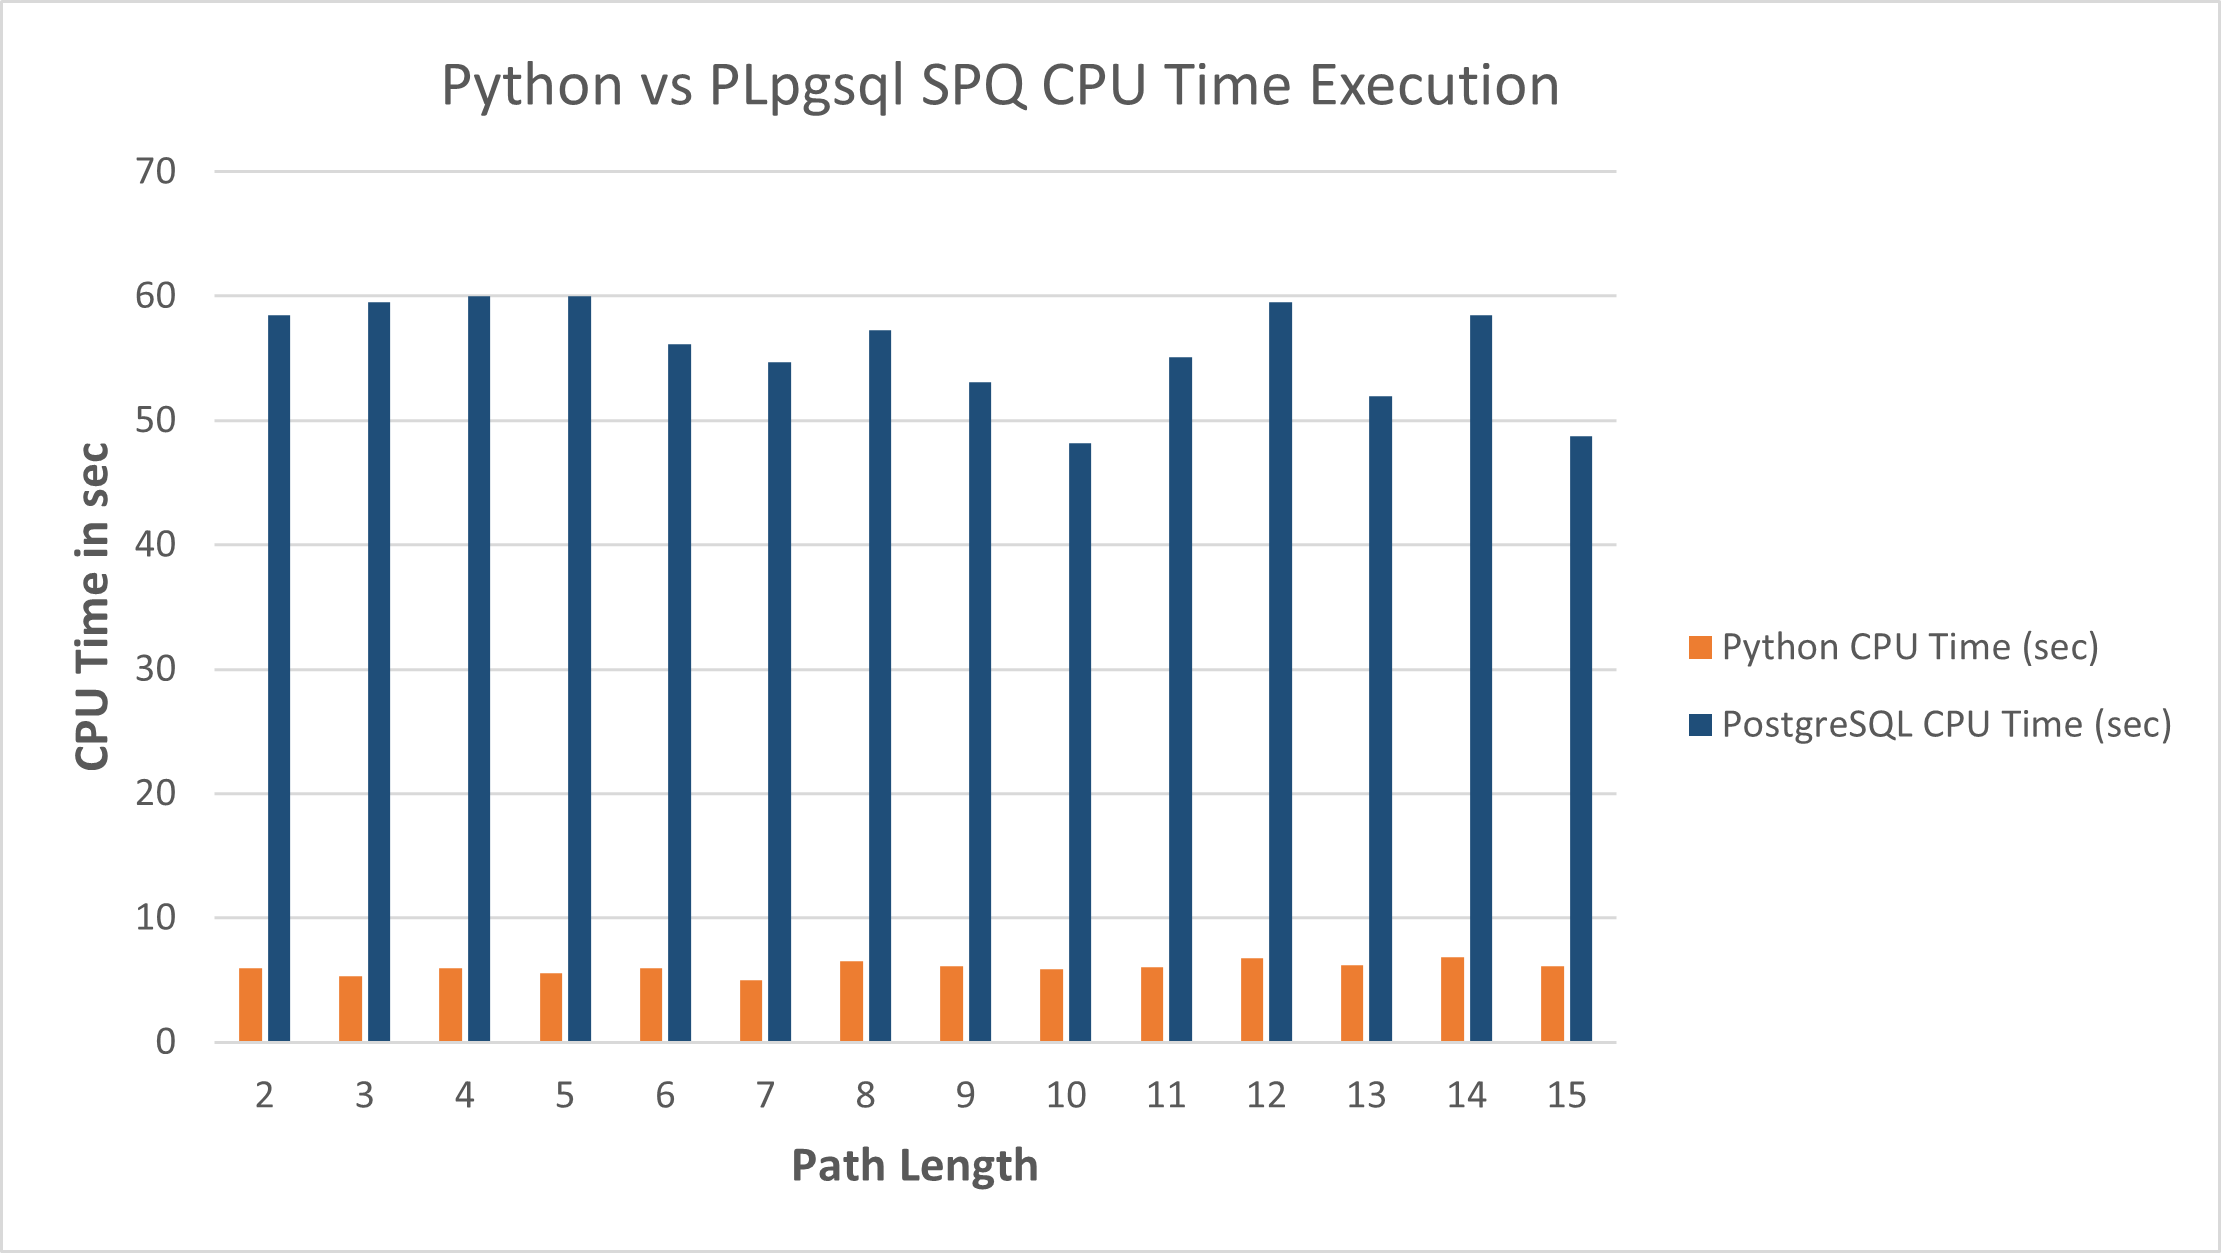

time: 0 ns (started: 2023-08-10 21:31:08 +03:00)


In [26]:
from IPython import display
display.Image(data=image_path, 
              alt="SPQ calls of batches of 20 queries in pythons and PL/pgSQL environments",
              height=400,
              width=600)

#### Step 4a: Fill the time series dataframe using the SPQ function
This dataset to be created will refer at each path and at each time interval the traffic flow in this path using the rules described in the following paper:

-  <b>SQP query paper: </b>https://dl.acm.org/doi/abs/10.1145/2666310.2666413

In [17]:
# create an empty dataframe
time_series_SPQ = pd.DataFrame(columns=time_intervals)

# fill the time series dataset
time_series_SPQ.insert(0,'Taxi ID',0)
time_series_SPQ.insert(1,'Traj ID',0)
time_series_SPQ.insert(2,'Path',0)
time_series_SPQ.insert(3,'Length',0)
time_series_SPQ['Path'] = paths['Path']
time_series_SPQ['Length'] = paths['Length']
time_series_SPQ['Taxi ID'] = paths['Taxi ID']
time_series_SPQ['Traj ID'] = paths['Traj ID']

time: 47 ms (started: 2023-08-10 21:24:55 +03:00)


In [ ]:
# fill the dataframe column by column (time to be completed: 25 minutes)
for time in time_intervals:
    i = 0
    examined_data = visited_segments[(visited_segments['Start Time'] >= time[0]) & (visited_segments['End Time'] <= time[1])].reset_index(drop=True)
    for path in paths['Path'].to_list():
        time_series_SPQ.at[i,time] = SPQ(path,time[0],time[1])
        i += 1

In [ ]:
# print the dataframe with SPQ traffic flow information
time_series_SPQ

In [ ]:
save_path = 'C:/Users/SK/Desktop/Diploma_Thesis/Datasets/San-Francisco-Yellow-Cabs/Files/time_series_SPQ.txt'
time_series_SPQ.to_csv(save_path,index=False)

#### Step 4b: Fill the second time series dataframe without using the SPQ rules
In this case, the traffic flow information at each path and at each time interval does not follow the conditions and rules that the SPQ function denotes. So in this dataset, traffic flow at each path will describe that in a specific time interval, a number of moving objects have crossed all the edge ids (roads) contained in a specific path.

In [19]:
# create an empty dataframe
time_series_without_SPQ = pd.DataFrame(columns=time_intervals)

# fill the time series dataset
time_series_without_SPQ.insert(0,'Taxi ID',0)
time_series_without_SPQ.insert(1,'Traj ID',0)
time_series_without_SPQ.insert(2,'Path',0)
time_series_without_SPQ.insert(3,'Length',0)
time_series_without_SPQ['Path'] = paths['Path']
time_series_without_SPQ['Length'] = paths['Length']
time_series_without_SPQ['Taxi ID'] = paths['Taxi ID']
time_series_without_SPQ['Traj ID'] = paths['Traj ID']

time: 16 ms (started: 2023-08-10 21:27:07 +03:00)


##### Use a function to fill the times series dataset without the use of SPQ
The given code defines a function called traffic_flow_without_SPQ that takes a list <b>path</b> and two time parameters <b>time_enter</b> and <b>time_leave</b>. It aims to find the count of trajectories in some data, where the given path is entirely covered by the 'OSM Way ID' values associated with each trajectory and taxi, based on the specified time interval.

In [20]:
def traffic_flow_without_SPQ(path, time_enter, time_leave):
    # Initialize the count of matching trajectories
    trajectories = 0
    
    # extract only the data that match the time interval given as input
    # examined_data = visited_segments[(visited_segments['Start Time'] >= time_enter) & (visited_segments['End Time'] <= time_leave)].reset_index(drop=True)

    # find the indexes of entries in 'examined_data' where 
    # the first element of the 'path' is present in the 'OSM Way ID' column
    needed_indexes = examined_data[examined_data['OSM Way ID'] == path[0]].index

    # convert the 'path' list to a set for efficient subset check
    path_roads = set(path)

    # loop through the needed indexes to check for matching trajectories
    for index in needed_indexes:
        
        # get the 'Traj ID' and 'Taxi ID' for the current index
        traj_id = examined_data.at[index, 'Traj ID']
        taxi_id = examined_data.at[index, 'Taxi ID']

        # find all the 'OSM Way ID' values for the current 'Traj ID' and 'Taxi ID'
        selected_roads = set(examined_data[(examined_data['Traj ID'] == traj_id) & (examined_data['Taxi ID'] == taxi_id)]['OSM Way ID'])
        
        # check if the 'path_roads' is a subset of 'selected_roads'
        if path_roads.issubset(selected_roads):
            
            # increment the count of matching trajectories
            trajectories += 1

    # return the count of matching trajectories
    return trajectories


time: 0 ns (started: 2023-08-10 21:27:26 +03:00)


In [ ]:
# fill the dataframe column by column (time to be completed: 2 hours)
for time in time_intervals:
    i = 0
    examined_data = visited_segments[(visited_segments['Start Time'] >= time[0]) & (visited_segments['End Time'] <= time[1])].reset_index(drop=True)
    for path in paths['Path'].to_list():
        time_series_without_SPQ.at[i,time] = traffic_flow_without_SPQ(path,time[0],time[1])
        i += 1

In [ ]:
# print the dataframe without the SPQ traffic flow information
time_series_without_SPQ

In [ ]:
# save dataframe to CSV format
save_path_2 = 'C:/Users/SK/Desktop/Diploma_Thesis/Datasets/San-Francisco-Yellow-Cabs/Files/time_series_without_SPQ.txt'
time_series_without_SPQ.to_csv(save_path_2,index=False)

##### Plot the distribution of paths created with respect to the length

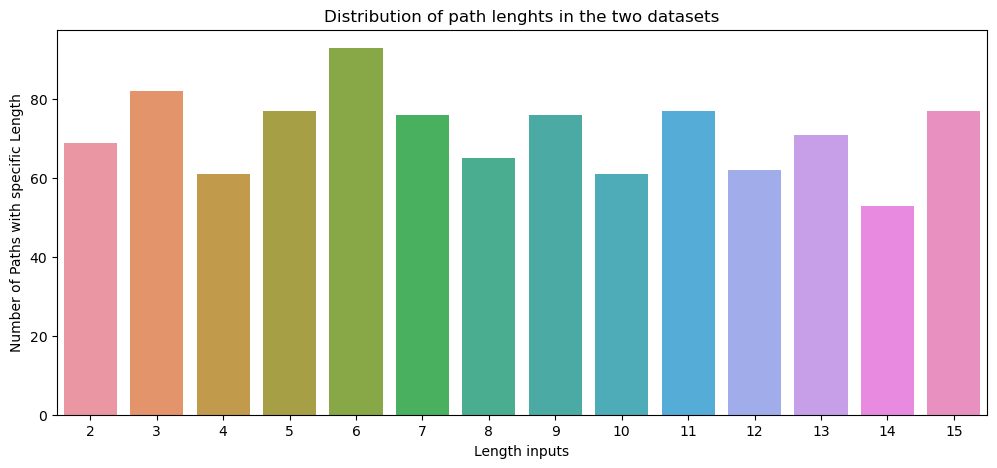

time: 1.33 s (started: 2023-08-10 21:29:27 +03:00)


In [23]:
# count the number of paths grouped by length attribute
plt.figure(figsize=(12,5))
sns.countplot(time_series_SPQ,x='Length')
plt.xlabel('Length inputs')
plt.ylabel('Number of Paths with specific Length')
plt.title('Distribution of path lenghts in the two datasets')
plt.show()